In [1]:
import os, random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import InterfacePreprocessing as IntPre

from PIL import Image
from scipy.ndimage import imread
from scipy.misc import imresize
from scipy.stats import pearsonr
from sklearn.metrics import roc_curve, auc
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Defining global variables

In [2]:
global raw_only, image_size, num_layer
raw_only = False
raw_image_size = 250
image_size= 88
if raw_only:
    num_layer = 1
else:
    num_layer = 6

p_matching = 0.5
num_filter_1 = 20
num_filter_2 = 40
num_filter_3 = 60

In [3]:
# ############### #
#   Helper Func   #
# ############### #

'''
# Create the same image merge with maximum 3 kind of pre-processing
def preprocessing_bare(image, size):
    
    if raw_only:
        image_temp = np.zeros((size,size,1))
        image = imresize(image, [size, size])
        image_temp[:,:,0] = image
    else:
        image_temp = np.zeros((size,size,4))
        image = imresize(image, [size, size])
        image_temp[:,:,0] = image # 180*180
        image_temp[:,:,1] = imresize(IntPre.frequency(image, step=5), [size, size])
        image_temp[:,:,2] = imresize(np.abs(IntPre.orientation(image, coherence=False)), [size, size])
        image_temp[:,:,3] = imresize(IntPre.variance(image, block=5), [size, size])
        
    return image_temp

# To load images like CASIA (no matching etc...)
def load_vrac(path):
    images = dict()

    for f in os.listdir(path):
        ID = f[:-4]
        image = imread(path+f).astype(np.int32)
        image_temp = preprocessing_bare(image, raw_image_size)
        images[ID] = image_temp
    return images

# To load images organised by pairs (of match and mismatch)
def load_pairs(path_match, path_mismatch):
    return load_vrac(path_match), load_vrac(path_mismatch)

# If images are loaded with "load_pairs"
def generate_batch_pairs(images_match, images_mismatch, num, image_size):
        
    x = np.zeros((num, image_size*image_size*num_layer))
    x_p = np.zeros((num, image_size*image_size*num_layer))
    y = np.zeros((num, 1))
    match = int(np.round(num*0.5))
    mis_match = num - match

    keys_mismatch = images_mismatch.keys()
    for i in range(mis_match):
        ID = random.choice(keys_mismatch)[:-1]
        img = images_mismatch[ID + '0']
        x1 = img[:88,:88,:]
        x2 = img[4:92,:88,:]
        x[i,:] = np.reshape(x1, (1,image_size*image_size*num_layer))
        x_p[i,:] = np.reshape(x2, (1,image_size*image_size*num_layer))
        y[i] = 0

    keys_match = images_match.keys()
    for i in range(match):
        ID = random.choice(keys_match)[:-1]
        img = images_match[ID + '0']
        x1 = img[:88,:88,:]
        x2 = img[88:176,:88,:]      
        x[mis_match+i,:] = np.reshape(x1, (1,image_size*image_size*num_layer))
        x_p[mis_match+i,:] = np.reshape(x2, (1,image_size*image_size*num_layer))
        y[mis_match+i] = 1
        
    return [x, x_p, y]
'''

def load_pairs_from_preprocessed(match_path, mismatch_path):
    # Notice that the preprocessed data has 94 images for match and mismatch each

    images_match = dict()
    images_mismatch = dict()

    for ID in range(94):
        for pic in range(2):
            
            image_temp1 = np.zeros((image_size,image_size,num_layer))
            image_temp2 = np.zeros((image_size,image_size,num_layer))
            
            for layer in range(num_layer):
                
                fname = str(ID+1)+'_'+str(pic)+'_'+str(layer)+'.png'
                image_temp1[:,:,layer] = imresize(imread(match_path+fname).astype(np.int32),[image_size,image_size])

                fname = str(ID+1)+'_'+str(pic)+'_'+str(layer)+'.png'
                image_temp2[:,:,layer] = imresize(imread(mismatch_path+fname).astype(np.int32),[image_size,image_size])
                
            images_match[str(ID+1)+'_'+str(pic)] = image_temp1
            images_mismatch[str(ID+1)+'_'+str(pic)] = image_temp2
            
    return images_match, images_mismatch

def generate_batch_pairs_from_preprocessed(images_match, images_mismatch, num, image_size):
        
    x = np.zeros((num, image_size*image_size*num_layer))
    x_p = np.zeros((num, image_size*image_size*num_layer))
    y = np.ones((num, 1))*-1
    match = int(np.round(num*0.5))
    mis_match = num - match

    keys_mismatch = images_mismatch.keys()
    for i in range(mis_match):
        ID = random.choice(keys_mismatch)[:-1]
        img = images_mismatch[ID + '0']
        img_p = images_mismatch[ID + '1']
        x[i,:] = np.reshape(img, (1,image_size*image_size*num_layer))
        x_p[i,:] = np.reshape(img_p, (1,image_size*image_size*num_layer))
        y[i] = 0

    keys_match = images_match.keys()
    for i in range(match):
        ID = random.choice(keys_match)[:-1]
        img = images_match[ID + '0']
        img_p = images_match[ID + '1']  
        x[mis_match+i,:] = np.reshape(img, (1,image_size*image_size*num_layer))
        x_p[mis_match+i,:] = np.reshape(img_p, (1,image_size*image_size*num_layer))
        y[mis_match+i] = 1
        
    return [x, x_p, y]

# ################## #
# Helper Func for tf #
# ################## #

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.3, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride=[1, 1, 1, 1]):
    return tf.nn.conv2d(x, W, strides=stride, padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
def sigm(x):
    return tf.sigmoid(x)



In [4]:
# ################## #
#     Old Version    #
# ################## #

# images_match, images_mismatch = load_pairs("./PAIRS/MATCHED/CROP/", "./PAIRS/MISMATCHED/CROP/")

# for key in images_match.keys():
#     images_match[key][:,:,2] = np.abs(IntPre.orientation(images_match[key][:,:,0], coherence=False))
    
# for key in images_mismatch.keys():
#     images_mismatch[key][:,:,2] = np.abs(IntPre.orientation(images_mismatch[key][:,:,0], coherence=False))

# ################## #
#     New Version    #
# ################## #
images_match, images_mismatch = load_pairs_from_preprocessed("./PreProcessed/Match/", "./PreProcessed/MisMatch/")

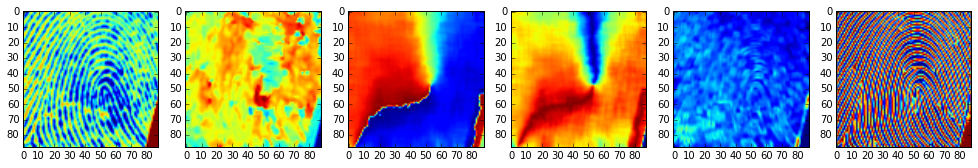

In [5]:
key = images_match.keys()[0]
plt.figure(figsize=(17,5))
for i in range(6):
    ax = plt.subplot(1,6,i+1)
    ax.imshow(images_match[key][:,:,i])

# Creating a new TF session and defining Shared Weights

In [6]:
# sess = tf.InteractiveSession()

# These two are input images
x = tf.placeholder(tf.float32, shape=[None, image_size*image_size*num_layer])
x_p = tf.placeholder(tf.float32, shape=[None, image_size*image_size*num_layer])

# y_ is just a value 0(match) or 1(no match) for the two input images
y_ = tf.placeholder(tf.float32, shape=[None, 1])

# Dropout coefficient
keep_prob = tf.placeholder(tf.float32)

# sess.run(tf.initialize_all_variables())

W_conv1 = weight_variable([7, 7, num_layer, num_filter_1])
b_conv1 = bias_variable([num_filter_1])

W_conv2 = weight_variable([5, 5, num_filter_1, num_filter_2])
b_conv2 = bias_variable([num_filter_2])

W_conv3 = weight_variable([5, 5, num_filter_2, num_filter_3])
b_conv3 = bias_variable([num_filter_3])

W_conv1_p = weight_variable([7, 7, num_layer, num_filter_1])
b_conv1_p = bias_variable([num_filter_1])

W_conv2_p = weight_variable([5, 5, num_filter_1, num_filter_2])
b_conv2_p = bias_variable([num_filter_2])

W_conv3_p = weight_variable([5, 5, num_filter_2, num_filter_3])
b_conv3_p = bias_variable([num_filter_3])

W_fc1 = weight_variable([image_size/4*image_size/4*num_filter_3, 1024])
b_fc1 = bias_variable([1024])

W_fc2 = weight_variable([1024, 2])
b_fc2 = bias_variable([2])

# Two Sides of Siamese Net

In [7]:
# ############### #
#      Side 1     #
# ############### #

# Input Image
x_image = tf.reshape(x, [-1,image_size,image_size,num_layer])

# First Conv Layer - after maxpool 44*44
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second Conv Layer - after maxpool 22*22
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Third Conv Layer - after maxpool 11*11
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

# Final Data Processing Step
z = tf.reshape(h_pool3, [-1,image_size/4*image_size/4*num_filter_3])
# z = tf.reshape(h_pool3, [-1,4*4*256])
z_norm = tf.pow(tf.reduce_sum(tf.pow(z, 2), reduction_indices=1),0.5)

h_fc1 = tf.nn.relu(tf.matmul(z, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

# ############### #
#      Side 2     #
# ############### #

# Input Image
x_image_p = tf.reshape(x_p, [-1,image_size,image_size,num_layer])

# First Conv Layer - after maxpool 44*44
h_conv1_p = tf.nn.relu(conv2d(x_image_p, W_conv1_p) + b_conv1_p)
h_pool1_p = max_pool_2x2(h_conv1_p)

# Second Conv Layer - after maxpool 22*22
h_conv2_p = tf.nn.relu(conv2d(h_pool1_p, W_conv2_p) + b_conv2_p)
h_pool2_p = max_pool_2x2(h_conv2_p)

# Third Conv Layer - after maxpool 11*11
h_conv3_p = tf.nn.relu(conv2d(h_pool2_p, W_conv3_p) + b_conv3_p)
h_pool3_p = max_pool_2x2(h_conv3_p)

# Final Data Processing Step
z_p = tf.reshape(h_pool3_p, [-1,image_size/4*image_size/4*num_filter_3])
# z_p = tf.reshape(h_pool3_p, [-1,4*4*256])
z_p_norm = tf.pow(tf.reduce_sum(tf.pow(z_p, 2), reduction_indices=1),0.5)

h_fc1_p = tf.nn.relu(tf.matmul(z_p, W_fc1) + b_fc1)
h_fc1_p_drop = tf.nn.dropout(h_fc1, keep_prob)

y_conv_p=tf.nn.softmax(tf.matmul(h_fc1_p_drop, W_fc2) + b_fc2)

# Actual Calculation

In [15]:
# distance = tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm)
# cross_entropy = tf.pow(tf.reduce_sum(tf.pow(distance, 2), reduction_indices=1), 0.5)

cross_entropy = tf.py_func(pearsonr, [y_conv, y_conv_p], [tf.float32])

# train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
sess = tf.Session()
sess.run(tf.initialize_all_variables())

for i in range(100):
    batch = generate_batch_pairs_from_preprocessed(images_match, images_mismatch, 50, image_size)
    if i%10 == 0:
#         train_accuracy = accuracy.eval(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})
#         print("step %d, training accuracy %g"%(i, train_accuracy))
        c_e = cross_entropy.eval(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})
        print c_e
#     train_step.run(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})

AttributeError: 'list' object has no attribute 'eval'

In [ ]:
distance = tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm)
batch = generate_batch_pairs_from_preprocessed(images_match, images_mismatch, 50, image_size)

prediction = []
results = distance.eval(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})
# for i in range(50):
#     if results[0][i]<0:
#         prediction.append(1)
#     else:
#         prediction.append(0)
    
# accuracy = np.mean(np.equal(prediction, np.concatenate(batch[2])))
print results

# Below is the test on MNIST

In [ ]:
def generate_batch_mnist(n, mode='train'):
    x, x_p = np.zeros((n, 784)), np.zeros((n, 784))
    y = np.zeros((n,1))
    
    matched = 0
    mismatched = np.round(n/2)
    while matched < np.round(n/2):
        if mode == 'train':
            batch = mnist.train.next_batch(2, )
        elif mode == 'test':
            batch = mnist.test.next_batch(2)
        else:
            batch = mnist.validation.next_batch(2)
        
        if np.argmax(batch[1],axis=1)[0] == np.argmax(batch[1],axis=1)[1]:
            x[matched,:] = batch[0][0,:]
            x_p[matched,:] = batch[0][1,:]
            y[matched] = 1
            matched += 1
            
        elif mismatched > 0:
            x[-mismatched,:] = batch[0][0,:]
            x_p[-mismatched,:] = batch[0][1,:]
            mismatched -= 1
            
    return [x, x_p, y]

In [ ]:
batch = generate_batch_mnist(2)

for i in range(2):
    plt.figure()
    ax = plt.subplot(1,2,1)
    ax.imshow(np.reshape(batch[0][i,:],(28,28)))
    ax = plt.subplot(1,2,2)
    ax.imshow(np.reshape(batch[1][i,:],(28,28)))

In [ ]:
distance = tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm) - tf.transpose(y_)
cross_entropy = tf.pow(tf.reduce_sum(tf.pow(distance, 2), reduction_indices=1),0.5)

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

rounded = tf.round(cross_entropy*-1)
correct_prediction = tf.equal(rounded,tf.transpose(y_))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess.run(tf.initialize_all_variables())

for i in range(10000):
    mnist_batch = generate_batch_mnist(50, 'train')
    if i%500 == 0:
        c_e = cross_entropy.eval(feed_dict={x:mnist_batch[0], x_p:mnist_batch[1], y_: mnist_batch[2], keep_prob: 1.0})
        print c_e
#         print "Accuracy %g" %accuracy.eval(feed_dict={x:mnist_batch[0], x_p:mnist_batch[1], y_: mnist_batch[2], keep_prob: 1.0})

    train_step.run(feed_dict={x:mnist_batch[0], x_p:mnist_batch[1], y_: mnist_batch[2], keep_prob: 1.0})